## 1. Overall

In [4]:
import os, sys, time, warnings, re
import pandas as pd
import seaborn as sns
import datetime as dt
import lightgbm as lgb
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from fnmatch import fnmatch, fnmatchcase
from mpl_toolkits.mplot3d import Axes3D

sys.path.append(os.path.abspath(os.path.dirname("../")))
from modules import edaViz

warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
trainLabels.to_hdf("../dataset/edaViz/trainHist.h5", "trainHist")
testLabels.to_hdf("../dataset/edaViz/testHist.h5", "testHist")
histTrans.to_hdf("../dataset/edaViz/histTrans.h5", 'histTrans')

In [5]:
%%time
histTrans = pd.read_hdf("../dataset/edaViz/histTrans.h5", "histTrans")
trainLabels = pd.read_hdf("../dataset/edaViz/trainHist.h5", "trainHist")
testLabels = pd.read_hdf("../dataset/edaViz/testHist.h5", "testHist")

Wall time: 1min 54s


In [5]:
edaViz.printInfo('histTrans',histTrans)
edaViz.printDescribe('histTrans',histTrans)

histTrans information :  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         bool
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: bool(1), float64(2), int64(6), object(5)
memory usage: 3.1+ GB


histTrans Describe :  
             city_id  installments  merchant_category_id     month_lag  \
count  2.911236e+07  2.911236e+07          2.911236e+07  2.911236e+07   
mean   1.293256e+02  6.484954e-01          4.810130e+02 -4.487294e+00   
std    1.042563e+02  2.795577e+00          2.493757e+02  3.588800e+00   
min   -1.000000e+00 -1.000000e+00        

In [ ]:
histTransCount = Counter(histTrans['card_id'])
trainLabels['transCount'] = trainLabels['card_id'].apply(lambda row: histTransCount[row])
testLabels['transCount'] = testLabels['card_id'].apply(lambda row: histTransCount[row])

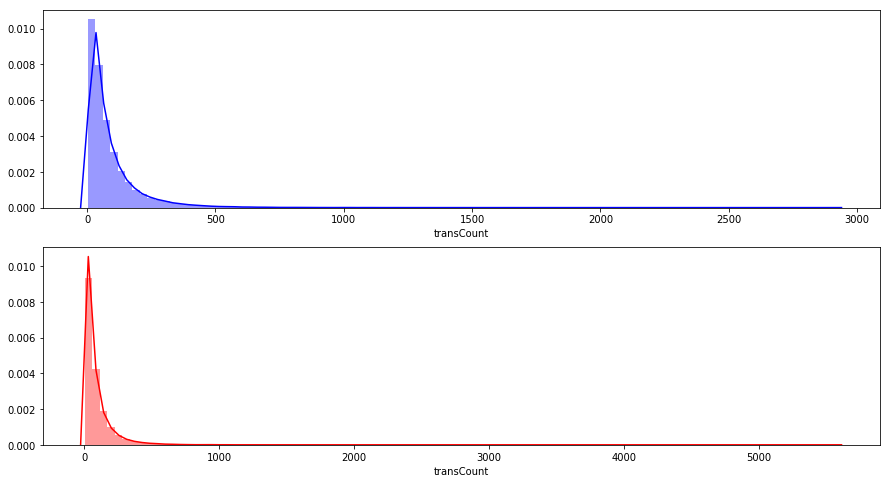

In [54]:
edaViz.compareTrainTest('transCount', bins=100)

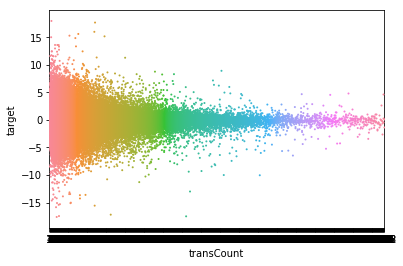

In [3]:
sns.stripplot(x=trainLabels['transCount'], y=trainLabels['target'], size=2)

## 2. authorized flag


### Overview

In [4]:
edaViz.printUniqCount(histTrans[['authorized_flag']])

authorized_flag Unique :  
 [ True False] 

authorized_flag Count :  
 True     26595452
False     2516909
Name: authorized_flag, dtype: int64 




In [ ]:
histTrans['authorized_flag'] = (histTrans['authorized_flag']=='Y')

### Counting Authorized Transaction

In [4]:
%%time
authGroup= histTrans[['card_id', 'authorized_flag']].groupby(['card_id'])
trainLabels['authCount'] = edaViz.mergeGroupby(trainLabels, authGroup['authorized_flag'], np.sum)
testLabels['authCount'] = edaViz.mergeGroupby(testLabels, authGroup['authorized_flag'], np.sum)

Wall time: 10.4 s


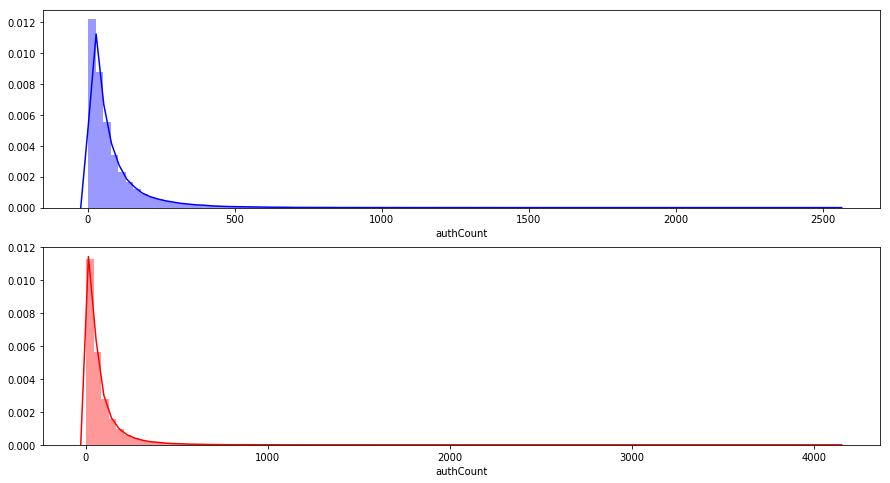

In [55]:
edaViz.compareTrainTest('authCount', bins=100)

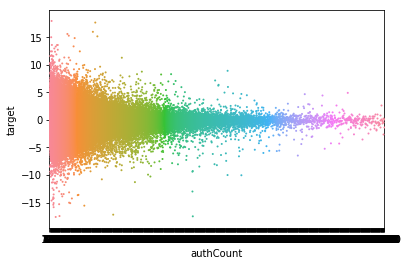

In [5]:
sns.stripplot(x=trainLabels['authCount'], y=trainLabels['target'], size=2)

Wall time: 24.3 s


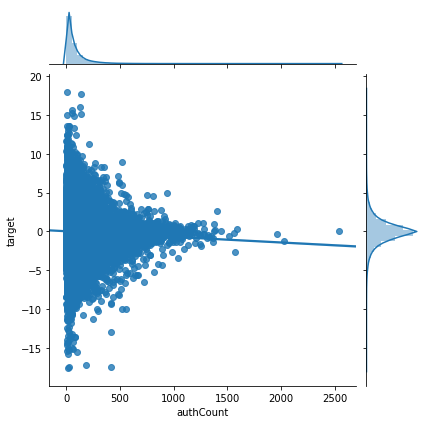

In [10]:
%time sns.jointplot(x=trainLabels['authCount'], y=trainLabels['target'], kind='reg')

### Authorized Transaction Ratio

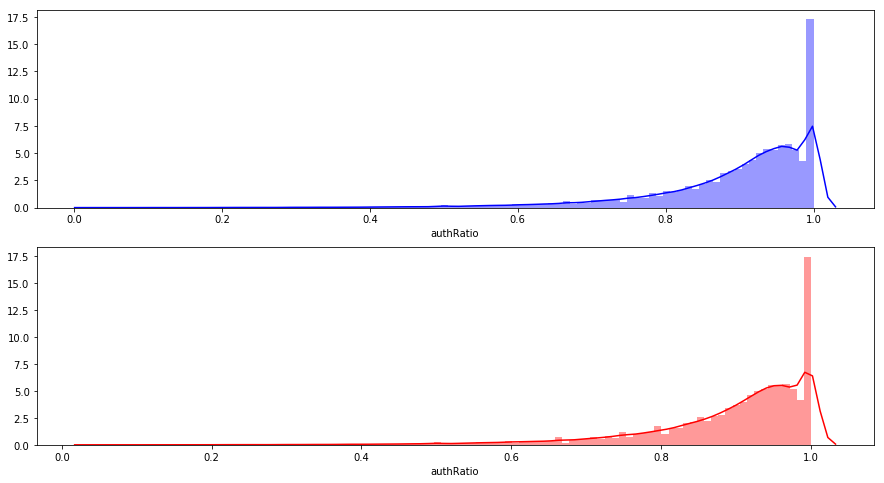

In [56]:
trainLabels['authRatio'] = trainLabels['authCount'] / trainLabels['transCount']
testLabels['authRatio'] = testLabels['authCount'] / testLabels['transCount']

compareTrainTest('authRatio', bins=100)

In [7]:
print('1 : ', trainLabels['card_id'][trainLabels['authRatio']==1].count())
for i in range(10):
    lower = i/10
    higher = (i+1)/10
    print('over {} ~ under {} : {}'.format(lower, higher,
        trainLabels['card_id'][trainLabels['authRatio']>=lower][trainLabels['authRatio']<higher].count()))

1 :  30755
over 0.0 ~ under 0.1 : 12
over 0.1 ~ under 0.2 : 73
over 0.2 ~ under 0.3 : 283
over 0.3 ~ under 0.4 : 593
over 0.4 ~ under 0.5 : 1335
over 0.5 ~ under 0.6 : 3442
over 0.6 ~ under 0.7 : 7544
over 0.7 ~ under 0.8 : 16987
over 0.8 ~ under 0.9 : 45688
over 0.9 ~ under 1.0 : 92998


Wall time: 25.1 s


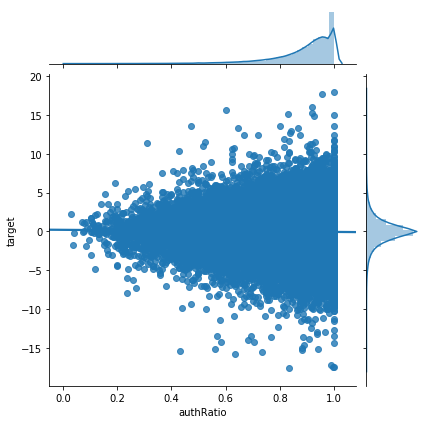

In [9]:
%time sns.jointplot(x=trainLabels['authRatio'], y=trainLabels['target'], kind='reg')

In [46]:
edaViz.briefLgb(['transCount','authCount','authRatio'])

{'rmse-mean': [1.718006152061217,
  1.7179806981671628,
  1.717951183799062,
  1.7179171197457463,
  1.717881157549042],
 'rmse-stdv': [0.010526363542579062,
  0.010524664469505934,
  0.010525239168952536,
  0.01052486734386209,
  0.010523236864912444]}

## 3. city id

In [45]:
len(histTrans['city_id'].unique())

308

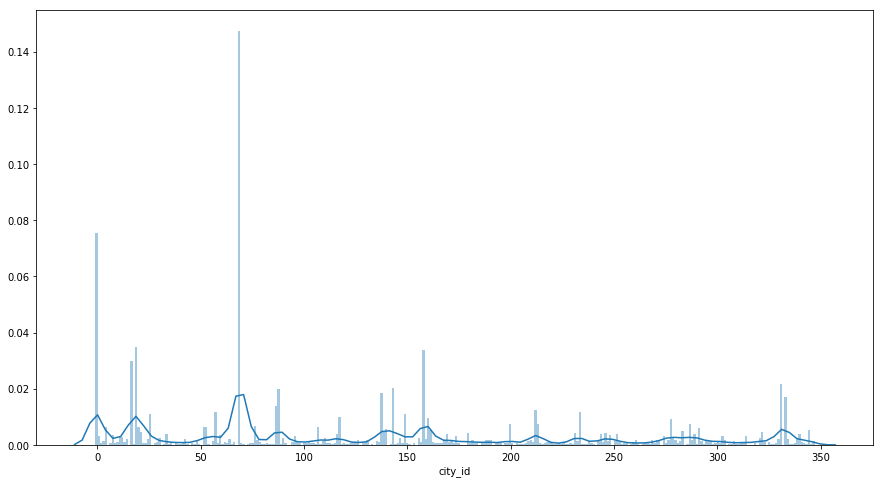

In [60]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
sns.distplot(histTrans['city_id'], bins=308, ax=ax)

In [27]:
%%time
def mode(x):
    cnt = Counter(x)
    return cnt.most_common(1)[0][0]

cityIdGroup = histTrans[['card_id','city_id']].groupby(['card_id'])
trainLabels['cityIdMode'] = edaViz.mergeGroupby(trainLabels, cityIdGroup['city_id'], mode)
testLabels['cityIdMode'] = edaViz.mergeGroupby(testLabels, cityIdGroup['city_id'], mode)

Wall time: 19.4 s


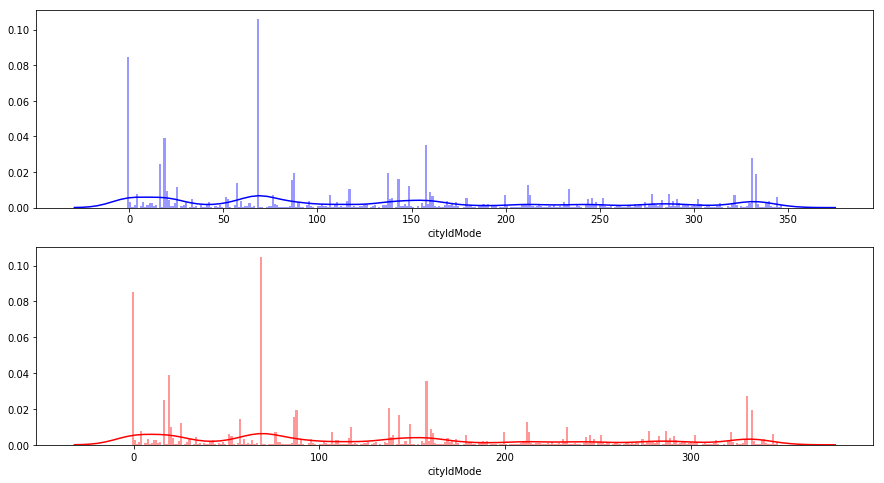

In [52]:
edaViz.compareTrainTest('cityIdMode', bins=308)

Wall time: 3min 1s


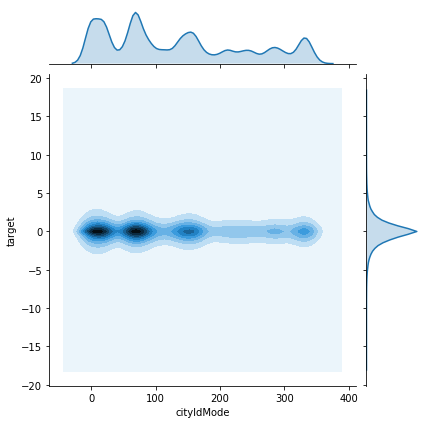

In [62]:
%time sns.jointplot(x=trainLabels['cityIdMode'], y=trainLabels['target'], kind='kde')

In [61]:
edaViz.briefLgb(['cityIdMode'])

{'rmse-mean': [1.718024940731373,
  1.7180223045874825,
  1.7180196187974204,
  1.7180170333969216,
  1.7180147389018436],
 'rmse-stdv': [0.010524628203679746,
  0.010524637123000266,
  0.01052453121403958,
  0.010524241338504062,
  0.010523958377458347]}

## 4. Categories

In [3]:
edaViz.printUniqCount(histTrans[['category_1','category_2','category_3']])

category_1 Unique :  
 ['N' 'Y'] 

category_1 Count :  
 N    27028332
Y     2084029
Name: category_1, dtype: int64 


category_2 Unique :  
 [ 1. nan  3.  5.  2.  4.] 

category_2 Count :  
  1.0    15177199
 3.0     3911795
 5.0     3725915
NaN      2652864
 4.0     2618053
 2.0     1026535
Name: category_2, dtype: int64 


category_3 Unique :  
 ['A' 'B' 'C' nan] 

category_3 Count :  
 A      15411747
B      11677522
C       1844933
NaN      178159
Name: category_3, dtype: int64 




In [4]:
histTrans = histTrans.rename(columns={'category_1':'cat1','category_2':'cat2','category_3':'cat3'})
histTrans['cat1'] = (histTrans['cat1']=='Y')
histTrans['cat2'] = histTrans['cat2'].apply(lambda row : '0' if np.isnan(row) else str(int(row)))
histTrans['cat3'] = histTrans['cat3'].apply(lambda row : 'D' if type(row)==float else row)

In [6]:
trainLabels = edaViz.mergeGroupby(trainLabels, histTrans[['card_id', 'cat1']], 'cat1', np.sum, rename='histCat1Cnt')
testLabels = edaViz.mergeGroupby(testLabels, histTrans[['card_id', 'cat1']], 'cat1', np.sum, rename='histCat1Cnt')

cat2Group = histTrans[['card_id', 'cat2']].groupby(['card_id', 'cat2']).size()
def cat2IdxerrHandler(x,y):
    try: return cat2Group[x][y]
    except IndexError: return 0
for i in range(6):
    trainLabels['histCat2Cnt'+str(i)] = trainLabels['card_id'].apply(lambda row : cat2IdxerrHandler(row,i))
    testLabels['histCat2Cnt'+str(i)] = testLabels['card_id'].apply(lambda row : cat2IdxerrHandler(row,i))
   
cat3Group = histTrans[['card_id','cat3']].groupby(['card_id','cat3']).size()
def cat3KeyerrHandler(x,y):
    try: return cat3Group[x][y]
    except KeyError: return 0
for i in ('A','B','C','D'):
    trainLabels['histCat3Cnt'+i] = trainLabels['card_id'].apply(lambda row : cat3KeyerrHandler(row, i))
    testLabels['histCat3Cnt'+i] = testLabels['card_id'].apply(lambda row : cat3KeyerrHandler(row, i))

In [73]:
for col in trainLabels.columns:
    if col.startswith('histCat'):
         edaViz.compareMeanStd(trainLabels, testLabels, col)

histCat1Cnt : Train - Test Difference
    Mean : 0.03%
    Std : 0.28%
histCat2Cnt0 : Train - Test Difference
    Mean : 0.00%
    Std : 0.02%
histCat2Cnt1 : Train - Test Difference
    Mean : 0.01%
    Std : 0.01%
histCat2Cnt2 : Train - Test Difference
    Mean : 0.00%
    Std : 0.01%
histCat2Cnt3 : Train - Test Difference
    Mean : 0.02%
    Std : 0.01%
histCat2Cnt4 : Train - Test Difference
    Mean : 0.00%
    Std : 0.06%
histCat2Cnt5 : Train - Test Difference
    Mean : 0.03%
    Std : 0.15%
histCat3CntA : Train - Test Difference
    Mean : 0.00%
    Std : 0.01%
histCat3CntB : Train - Test Difference
    Mean : 0.01%
    Std : 0.04%
histCat3CntC : Train - Test Difference
    Mean : 0.00%
    Std : 0.00%
histCat3CntD : Train - Test Difference
    Mean : 0.01%
    Std : 0.00%


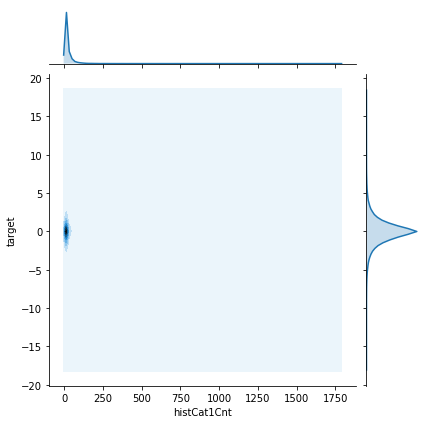

In [12]:
sns.jointplot(trainLabels['histCat1Cnt'], trainLabels['target'], kind='kde')

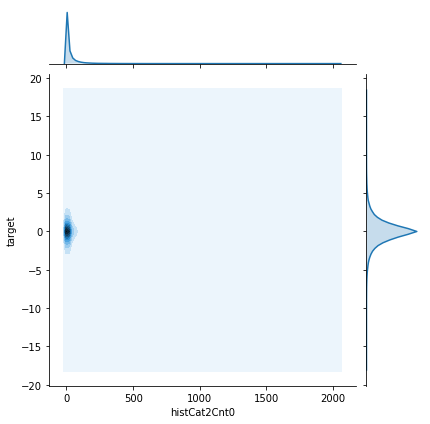

In [13]:
sns.jointplot(trainLabels['histCat2Cnt0'], trainLabels['target'], kind='kde')

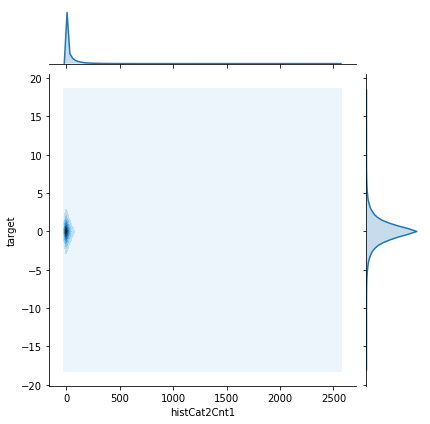

In [14]:
sns.jointplot(trainLabels['histCat2Cnt1'], trainLabels['target'], kind='kde')

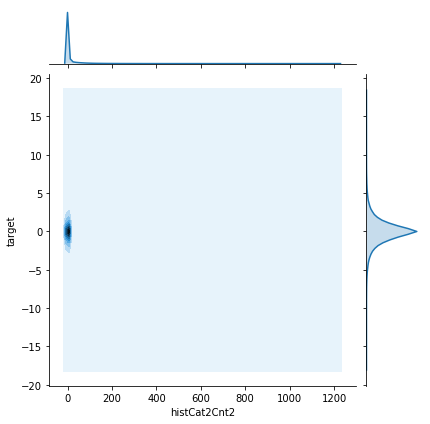

In [15]:
sns.jointplot(trainLabels['histCat2Cnt2'], trainLabels['target'], kind='kde')

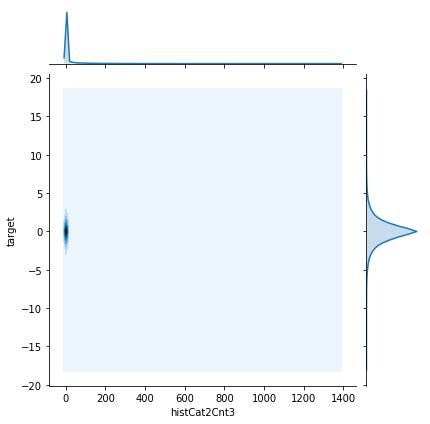

In [16]:
sns.jointplot(trainLabels['histCat2Cnt3'], trainLabels['target'], kind='kde')

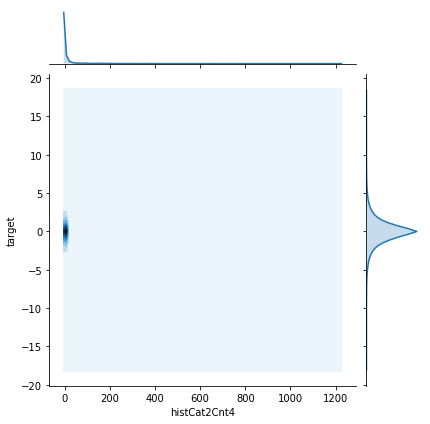

In [17]:
sns.jointplot(trainLabels['histCat2Cnt4'], trainLabels['target'], kind='kde')

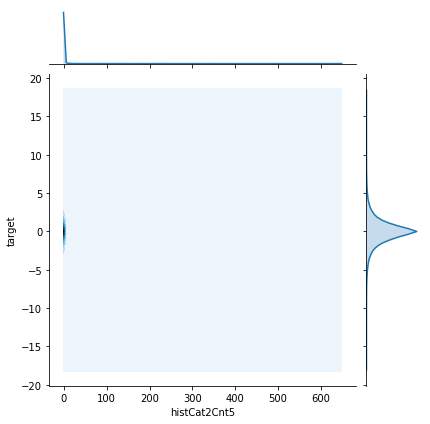

In [18]:
sns.jointplot(trainLabels['histCat2Cnt5'], trainLabels['target'], kind='kde')

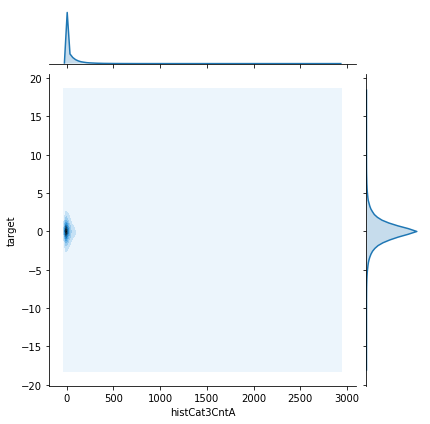

In [19]:
sns.jointplot(trainLabels['histCat3CntA'], trainLabels['target'], kind='kde')

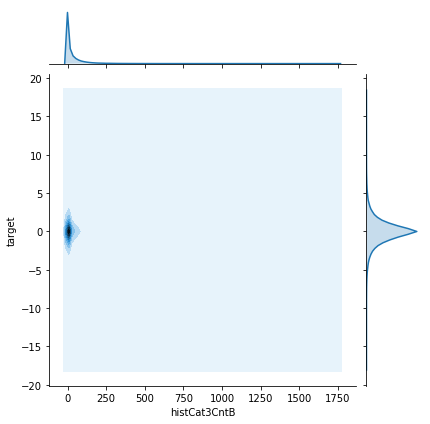

In [20]:
sns.jointplot(trainLabels['histCat3CntB'], trainLabels['target'], kind='kde')

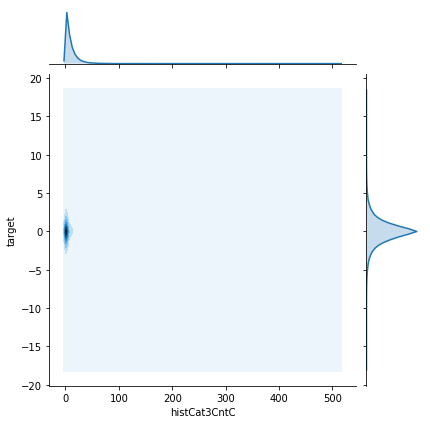

In [21]:
sns.jointplot(trainLabels['histCat3CntC'], trainLabels['target'], kind='kde')

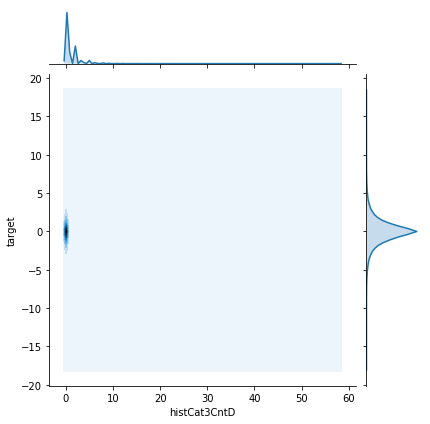

In [22]:
sns.jointplot(trainLabels['histCat3CntD'], trainLabels['target'], kind='kde')

In [36]:
for df in (trainLabels, testLabels):
    for col in df.columns:
        if fnmatch(col, 'histCat*Cnt*'):
            if col == 'histCat1Cnt' : df[col[:9]+'Ratio'] = df[col]/df['transCount']
            else: df[col[:9]+'Ratio'+col[-1]] = df[col]/df['transCount']

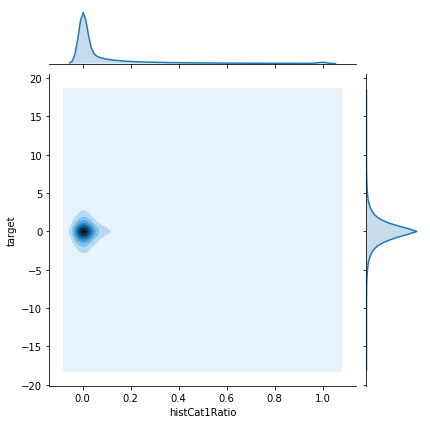

In [39]:
sns.jointplot(trainLabels['histCat1Ratio'], trainLabels['target'], kind='kde')

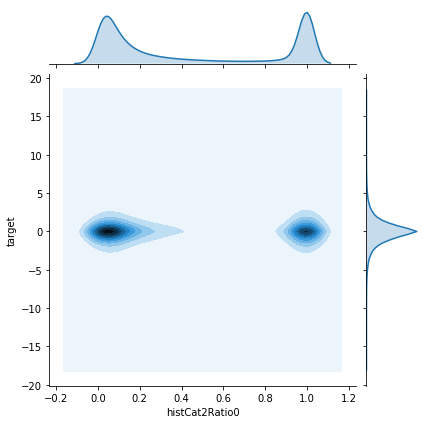

In [38]:
sns.jointplot(trainLabels['histCat2Ratio0'], trainLabels['target'], kind='kde')

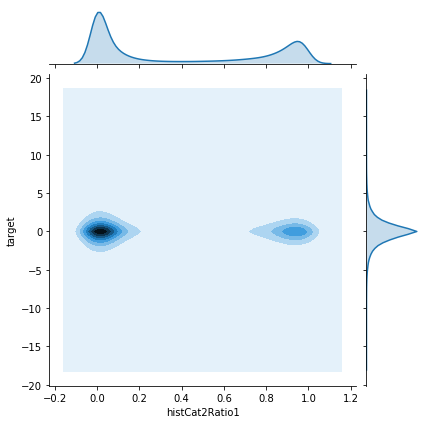

In [40]:
sns.jointplot(trainLabels['histCat2Ratio1'], trainLabels['target'], kind='kde')

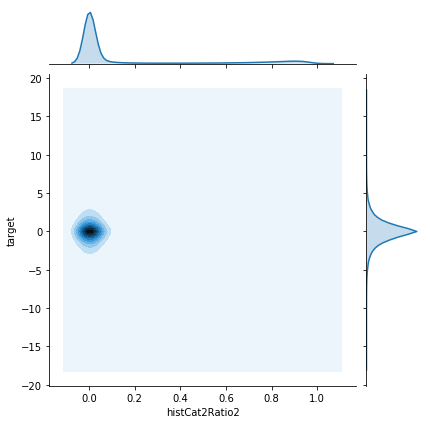

In [41]:
sns.jointplot(trainLabels['histCat2Ratio2'], trainLabels['target'], kind='kde')

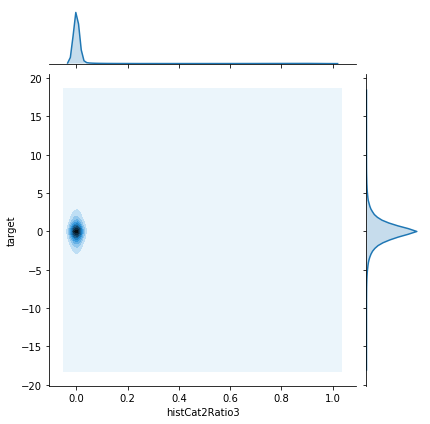

In [42]:
sns.jointplot(trainLabels['histCat2Ratio3'], trainLabels['target'], kind='kde')

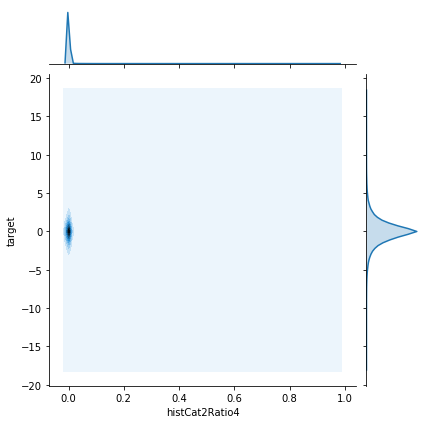

In [43]:
sns.jointplot(trainLabels['histCat2Ratio4'], trainLabels['target'], kind='kde')

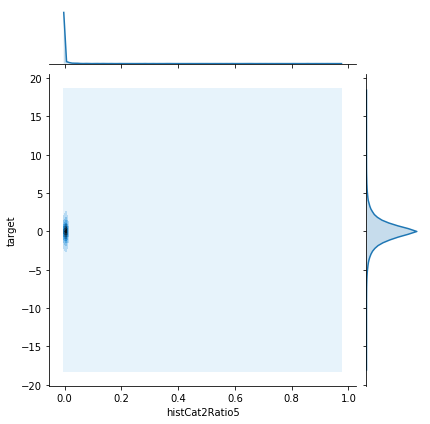

In [44]:
sns.jointplot(trainLabels['histCat2Ratio5'], trainLabels['target'], kind='kde')

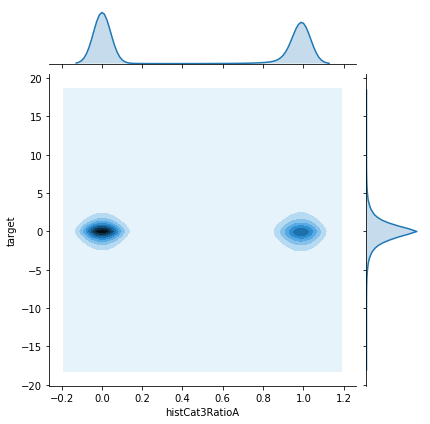

In [45]:
sns.jointplot(trainLabels['histCat3RatioA'], trainLabels['target'], kind='kde')

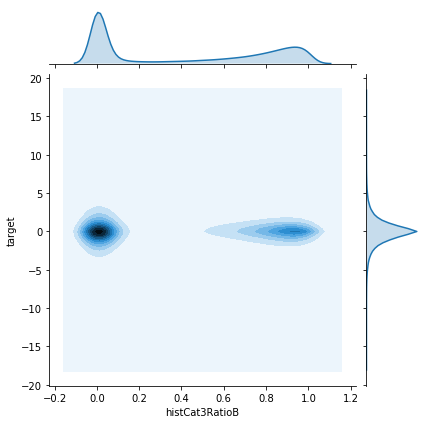

In [46]:
sns.jointplot(trainLabels['histCat3RatioB'], trainLabels['target'], kind='kde')

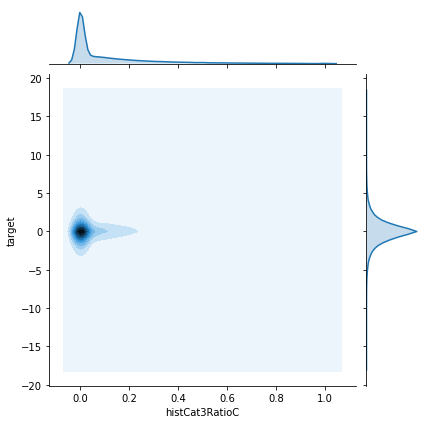

In [47]:
sns.jointplot(trainLabels['histCat3RatioC'], trainLabels['target'], kind='kde')

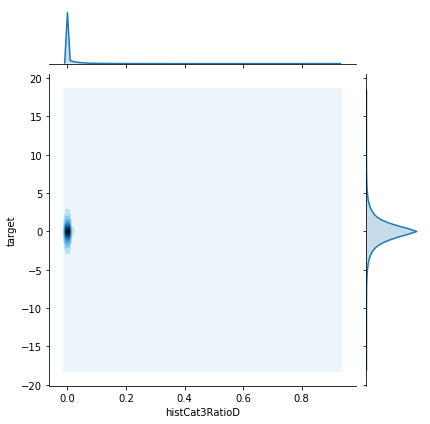

In [48]:
sns.jointplot(trainLabels['histCat3RatioD'], trainLabels['target'], kind='kde')

In [49]:
histCols = ['histCat3RatioD', 'histCat3RatioC','histCat3RatioB','histCat3RatioA',
            'histCat2Ratio5','histCat2Ratio4','histCat2Ratio3','histCat2Ratio2',
            'histCat2Ratio1','histCat2Ratio0','histCat1Ratio']
edaViz.briefLgb(histCols, trainLabels)

{'rmse-mean': [1.718026963891281,
  1.7180267826926223,
  1.7180266071779244,
  1.7180264391379716,
  1.718026279741958],
 'rmse-stdv': [0.01052439370330337,
  0.010524373833648258,
  0.010524350262917433,
  0.010524324432416987,
  0.01052429743990514]}

## 5. Installments

In [3]:
edaViz.printDescribe('installments', histTrans['installments'])

installments Describe :  
 count    2.911236e+07
mean     6.484954e-01
std      2.795577e+00
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      9.990000e+02
Name: installments, dtype: float64 




In [4]:
edaViz.printUniqCount(histTrans[['installments']])

installments Unique :  
 [  0   1   5   3   4   2  -1  10   6  12   8   7   9  11 999] 

installments Count :  
  0      15411747
 1      11677522
 2        666416
 3        538207
 4        179525
-1        178159
 6        132634
 10       118827
 5        116090
 12        55064
 8         20474
 7         10906
 9          5772
 11          830
 999         188
Name: installments, dtype: int64 




In [7]:
%%time
histTrans['installments'] = histTrans['installments'].replace([-1,999], [13,14])
instGroup = histTrans[['card_id', 'installments']].groupby(['card_id','installments']).size()

def instPrep(row):
    return instGroup[row][inst]
    
for inst in range(15):
    for df in (trainLabels, testLabels):
        df['histInstCnt'+str(inst)] = df['card_id'].apply(lambda row : edaViz.idxKeyErrHandler(row, instPrep, ext=0))

Wall time: 24min 24s


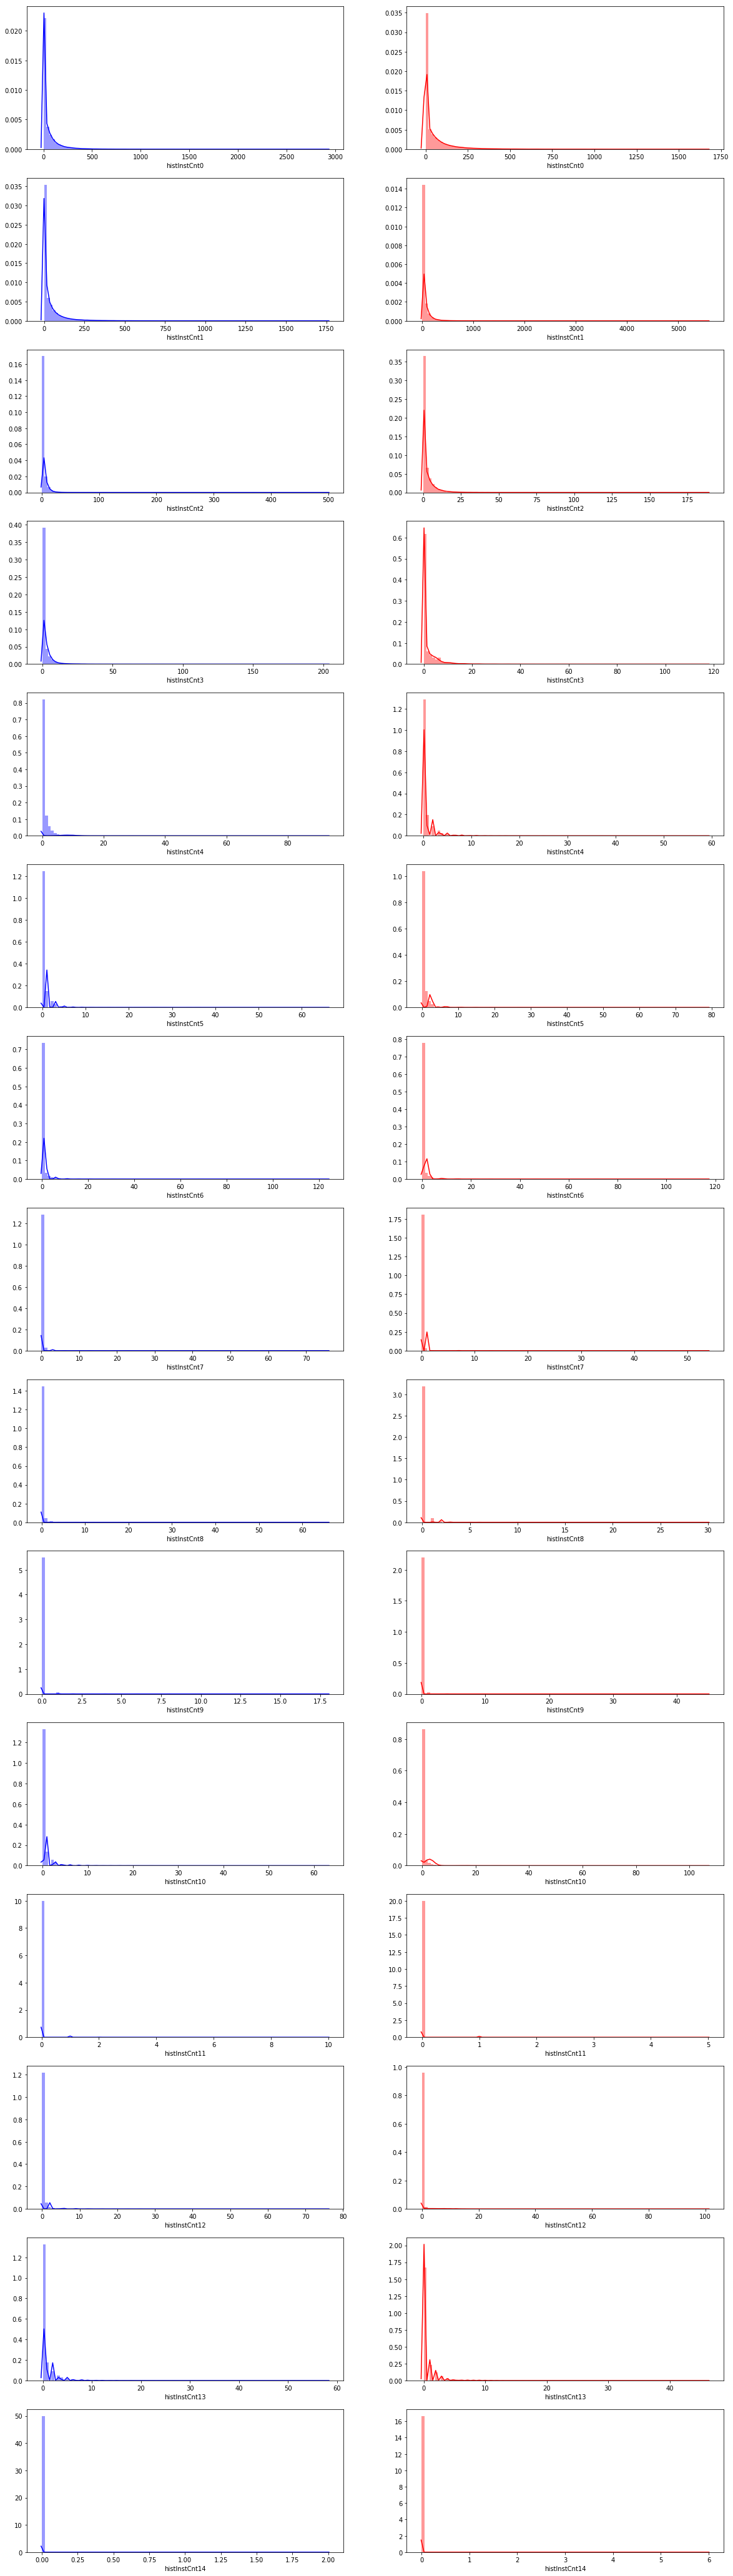

In [28]:
cols = [col for col in trainLabels.columns if col.startswith('histInstCnt')]
edaViz.compareTrainTest(cols, trainLabels, testLabels)

## 6. purchase amount

In [3]:
histTrans['purchase_amount'].describe()

count    2.911236e+07
mean     3.640090e-02
std      1.123522e+03
min     -7.469078e-01
25%     -7.203559e-01
50%     -6.883495e-01
75%     -6.032543e-01
max      6.010604e+06
Name: purchase_amount, dtype: float64

In [12]:
len(histTrans['purchase_amount'][histTrans['purchase_amount'] > 0])

1075467

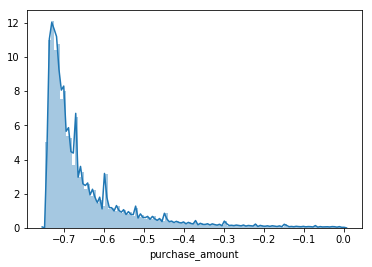

In [17]:
sns.distplot(histTrans['purchase_amount'][histTrans['purchase_amount']<0], bins=100)

In [6]:
trainLabels = edaViz.mergeGroupby(trainLabels, histTrans[['card_id', 'purchase_amount']], col='purchase_amount',  foo=np.mean,rename='amtMean')
testLabels = edaViz.mergeGroupby(testLabels, histTrans[['card_id', 'purchase_amount']], col='purchase_amount', foo=np.mean, rename='amtMean')
trainLabels = edaViz.mergeGroupby(trainLabels, histTrans[['card_id', 'purchase_amount']], col='purchase_amount',  foo=np.std, rename='amtStd')
testLabels = edaViz.mergeGroupby(testLabels, histTrans[['card_id', 'purchase_amount']], col='purchase_amount', foo=np.std,  rename='amtStd')

In [39]:
trainLabels['amtStd'].describe()

count    1.997100e+05
mean     1.271410e+01
std      3.886449e+03
min      0.000000e+00
25%      7.659110e-02
50%      1.603407e-01
75%      3.616569e-01
max      1.735112e+06
Name: amtStd, dtype: float64

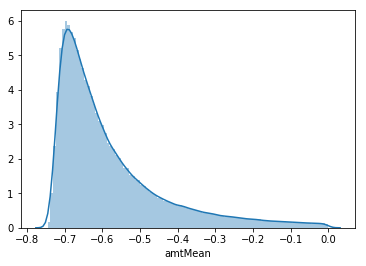

In [40]:
sns.distplot(trainLabels['amtMean'][trainLabels['amtMean']<0], bins=100)

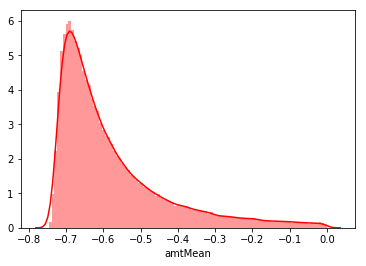

In [44]:
sns.distplot(testLabels['amtMean'][testLabels['amtMean']<0], bins=100, color='red')

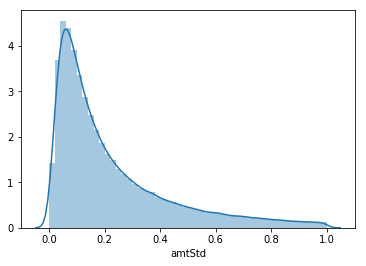

In [43]:
sns.distplot(trainLabels['amtStd'][trainLabels['amtStd']<1])

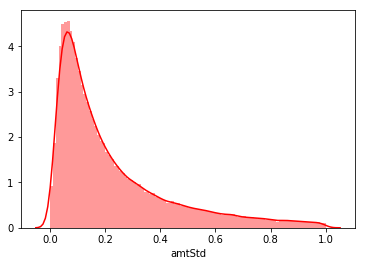

In [45]:
sns.distplot(testLabels['amtStd'][testLabels['amtStd']<1], bins=100, color='red')

Wall time: 361 ms


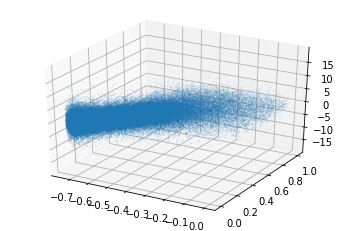

In [23]:
%%time 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# trainAmt3d = trainLabels[['amtMean', 'amtStd', 'target']][trainLabels['amtMean']<0][trainLabels['amtStd']<1]
ax.scatter(trainAmt3d['amtMean'], trainAmt3d['amtStd'], trainAmt3d['target'], s = 0.01)